# Package Imports

In [ ]:
!pip install yfinance --quiet

     |████████████████████████████████| 6.3 MB 20.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
# from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from fbprophet import Prophet
import plotly.express as px
# import pandas.util.testing as sm
import statsmodels.api as sm
import itertools
from statsmodels.tools.eval_measures import bic
from statsmodels.tools.eval_measures import aic
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pylab import rcParams


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper Functions

In [ ]:
def ilinechart(df, x, y, groups=None, title=''):
    fig = px.line(df, x=x, y=y, color=groups, title=title, template='none').update(layout=dict(title=dict(x=0.5)))
    fig.show()

In [ ]:
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50):
    
    ans = []
    for comb in pdq:
        for combs in pdqs:
            # try:
                mod = SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)#,
                                                # freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic, output.aic])
                # print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            # except:
            #     continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'aic'])
    return ans_df

In [ ]:
def test_stationarity(df, ts):
    """
    What is Stationarity test? for SOME TIMESERIES MODELS, before you fit the data you need to
    make sure it is stationary i.e the mean and variance does not change with time.
    
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
def wma(df, field, window):
    weights = np.arange(1, window+1)
    ma = df[field].rolling(window)
    wma= ma.apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
    return wma


# Stock Import

In [ ]:
data = yf.Ticker('TSLA')
data = data.history(period= '2y', interval='1d', rounding=True, )

In [ ]:
data.reset_index(inplace=True)
# data.rename(columns = {'Datetime':'date'}, inplace = True)
# data['date'] = pd.to_datetime(data['date'])


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          504 non-null    datetime64[ns]
 1   Open          504 non-null    float64       
 2   High          504 non-null    float64       
 3   Low           504 non-null    float64       
 4   Close         504 non-null    float64       
 5   Volume        504 non-null    int64         
 6   Dividends     504 non-null    int64         
 7   Stock Splits  504 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 31.6 KB


In [ ]:
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-09-23,48.00,49.04,47.84,48.25,21701000,0,0.0
1,2019-09-24,48.30,48.40,44.52,44.64,64457500,0,0.0
2,2019-09-25,44.91,45.80,43.67,45.74,47135500,0,0.0
3,2019-09-26,46.13,48.66,45.48,48.51,59422500,0,0.0
4,2019-09-27,48.44,49.74,47.75,48.43,55582000,0,0.0


## Visualize Price over Time

In [ ]:
ilinechart(data, 'Date', 'Close', title='Closing Prices Over Time')

# Exploration

## Stationarity Tests

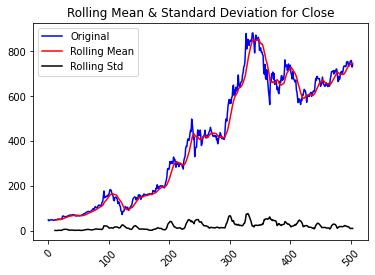

Results of Dickey-Fuller Test:
Test Statistic                  -0.804780
p-value                          0.817714
# Lags Used                      1.000000
Number of Observations Used    502.000000
Critical Value (1%)             -3.443444
Critical Value (5%)             -2.867315
Critical Value (10%)            -2.569846
dtype: float64


In [ ]:
test_stationarity(data,'Close')

In [ ]:
series = data[['Date','Close']]

In [ ]:
series = series.set_index('Date')

In [ ]:
decompose = sm.tsa.seasonal_decompose(series, model='additive', freq=232)
trend = decompose.trend.reset_index()
seasonality = decompose.seasonal.reset_index()
residuals = decompose.resid.reset_index()

In [ ]:
merged = series.merge(trend, on='Date')
merged = merged.merge(seasonality, on='Date')
merged = merged.merge(residuals, on='Date')
merged.columns = ['Date', 'Close', 'Trend', 'Seasonality', 'Residuals']

In [ ]:
melty = pd.melt(merged, id_vars='Date', value_vars=['Close', 'Trend', 'Seasonality', 'Residuals'], var_name='Variable', value_name='Value')

In [ ]:
ilinechart(melty, 'Date', 'Value', groups='Variable', title='Observed vs Components')

## Rolling Averages

In [ ]:
merged['Rolling_Mean'] = merged['Close'].rolling(window=232).mean()
merged['Rolling_Deviation'] = merged['Close'].rolling(window=232).std()

In [ ]:
melty1 = pd.melt(merged, id_vars='Date', value_vars=['Close', 'Rolling_Mean', 'Rolling_Deviation'], var_name='Variable', value_name='Value')
ilinechart(melty1, 'Date', 'Value', groups='Variable', title='Rolling Mean and Deviation')

In [ ]:
data['Weekly_WMA'] = wma(data, 'Close', 5)
data['Monthly_WMA'] = wma(data, 'Close', 21)
data['Quarterly_WMA'] = wma(data, 'Close', 63)
data['Yearly_WMA'] = wma(data, 'Close', 252)

In [ ]:
melty2 = pd.melt(data, id_vars='Date', value_vars=['Close', 'Weekly_WMA', 'Monthly_WMA','Quarterly_WMA','Yearly_WMA'], var_name='Variable', value_name='Value')
ilinechart(melty2, 'Date', 'Value', groups='Variable', title='Weekly MA vs WMA')

In [ ]:
data['Weekly_Err'] = data['Close'] - data['Weekly_WMA']
data['Monthly_Err'] = data['Close'] - data['Monthly_WMA']
data['Quarterly_Err'] = data['Close'] - data['Quarterly_WMA']
data['Yearly_Err'] = data['Close'] - data['Yearly_WMA']

In [ ]:
print('Weekly MAE:', data['Weekly_Err'].abs().mean(),
      '| Weekly RMSE:', np.sqrt(np.mean(data['Weekly_Err']**2)))
print('Monthly MAE:', data['Monthly_Err'].abs().mean(),
      '| Monthly RMSE:', np.sqrt(np.mean(data['Monthly_Err']**2)))
print('Quarterly MAE:', data['Quarterly_Err'].abs().mean(),
      ' | Quarterly RMSE:', np.sqrt(np.mean(data['Quarterly_Err']**2)))
print('Yearly MAE:', data['Yearly_Err'].abs().mean(),
      ' | Yearly RMSE:', np.sqrt(np.mean(data['Yearly_Err']**2)))

Weekly MAE: 9.190947999999997 | Weekly RMSE: 13.981983580244336
Monthly MAE: 24.714285714285715 | Monthly RMSE: 35.593046719815334
Quarterly MAE: 53.67223116650501  | Quarterly RMSE: 71.13597123167189
Yearly MAE: 146.17508486157817  | Yearly RMSE: 190.761143809238


## ADFuller Test

In [ ]:
stats = sm.tsa.stattools.adfuller(merged['Close'])
results = pd.Series(stats[0:4], index=['ADF Test Stat', 'P-Value', 'Lag (count)', 'Observation (count)'])
for key, value in stats[4].items():
  results[f'Critical Value {key}'] = value

print(results)

ADF Test Stat           -0.804780
P-Value                  0.817714
Lag (count)              1.000000
Observation (count)    502.000000
Critical Value 1%       -3.443444
Critical Value 5%       -2.867315
Critical Value 10%      -2.569846
dtype: float64


## ACF and PACF Plots 

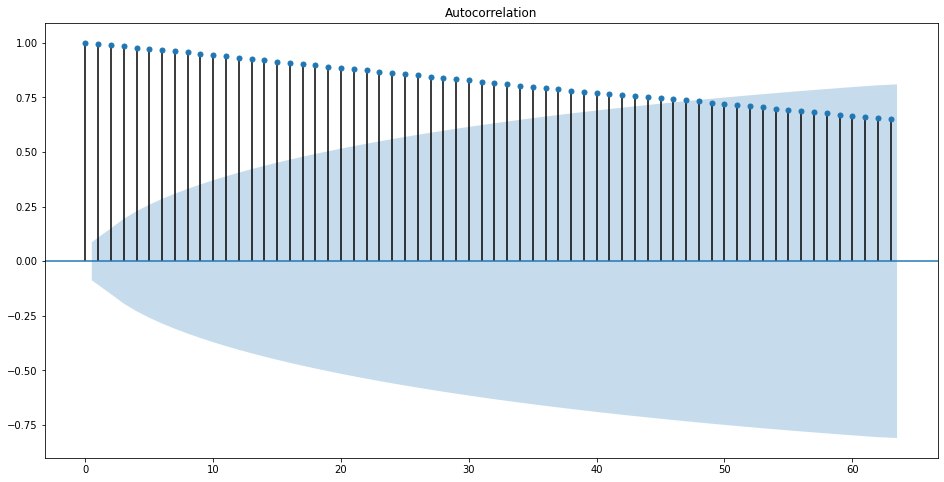

In [ ]:
rcParams['figure.figsize'] = 16, 8
fig = plot_acf(series, lags=63)

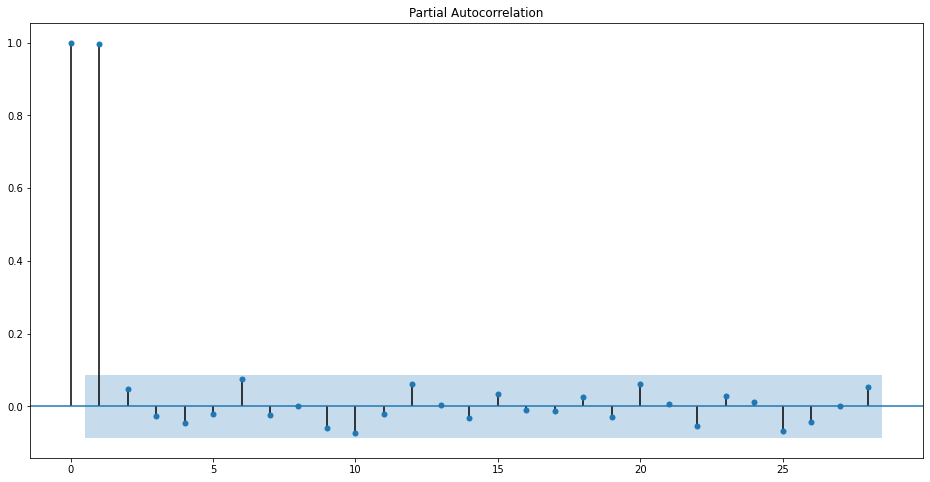

In [ ]:
rcParams['figure.figsize'] = 16, 8
fig = plot_pacf(series)


# SARIMAX training

In [ ]:
data.drop(columns=['Open','High','Low','Volume','Dividends','Stock Splits','Weekly_Err','Monthly_Err','Quarterly_Err','Yearly_Err'], inplace=True)
data.columns

Index(['Date', 'Close', 'Weekly_WMA', 'Monthly_WMA', 'Quarterly_WMA',
       'Yearly_WMA'],
      dtype='object')

In [ ]:
train = data.iloc[:-60]
test = data.iloc[-60:] 

In [ ]:
baseSARIMA = SARIMAX(data.Close, order=(2, 1, 1), seasonal_order=(1, 1, 1, 1)).fit()
sarima_full = baseSARIMA.predict()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
baseSARIMA1 = SARIMAX(data.Close, order=(2, 1, 1), seasonal_order=(1, 1, 1, 1)).fit()
sarima_close = baseSARIMA1.forecast(10)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
baseSARIMA2 = SARIMAX(data.Weekly_WMA, order=(2, 1, 1), seasonal_order=(1, 1, 1, 1)).fit()
sarima_weekly = baseSARIMA2.forecast(10)

In [ ]:
baseSARIMA3 = SARIMAX(data.Monthly_WMA, order=(2, 2, 1), seasonal_order=(1, 1, 1, 1)).fit()
sarima_monthly = baseSARIMA3.forecast(10)

In [ ]:
baseSARIMA4 = SARIMAX(data.Quarterly_WMA, order=(2, 1, 1), seasonal_order=(1, 1, 1, 1)).fit()
sarima_quarterly = baseSARIMA4.forecast(10)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [ ]:
baseSARIMA5 = SARIMAX(data.Yearly_WMA, order=(2, 1, 1), seasonal_order=(1, 1, 1, 1)).fit()
sarima_yearly = baseSARIMA5.forecast(10)

In [ ]:
data['weighted'] = data.Close*.35 + data.Weekly_WMA*.2 + data.Monthly_WMA*.1 + data.Quarterly_WMA*.05 + data.Yearly_WMA*.30

In [ ]:
baseSARIMA_ = SARIMAX(data.weighted, order=(2, 1, 1), seasonal_order=(1, 1, 1, 1)).fit()
sarima_weighted = baseSARIMA_.forecast(5)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
future = pd.DataFrame({'Date': pd.date_range(start=data.Date.iloc[-1], periods=30, 
                                                   freq='B', closed='right')})

In [ ]:
pred = pd.DataFrame()
pred['base'] = sarima_close
pred['base_wk'] = sarima_weekly
pred['base_mo'] = sarima_monthly
pred['base_qt'] = sarima_quarterly
pred['base_yr'] = sarima_yearly
pred['weighted'] = sarima_weighted

In [ ]:
test_ = pd.DataFrame()
test_['Date'] = future['Date']
test_ = data.merge(test_, how='outer', on='Date')
test_['BASE'] = sarima_full
test_['base'] = pred['base']
test_['base_wk'] = pred['base_wk']
test_['base_mo'] = pred['base_mo']
test_['base_qt'] = pred['base_qt']
test_['base_yr'] = pred['base_yr']
test_['weighted'] = pred['weighted']

In [ ]:
cols = test_.columns.to_list()
cols.remove('Weekly_WMA')
cols.remove('Monthly_WMA')
cols.remove('Quarterly_WMA')
cols.remove('Yearly_WMA')
test_ = test_[cols]
# cols

In [ ]:
sar_char = pd.melt(test_, id_vars='Date', var_name='Variable', value_name='Value', value_vars=list(test_.columns)[1:])
ilinechart(sar_char, 'Date', 'Value', groups='Variable', title='Forecast Comparison')

# Optimizing SARIMAX

In [ ]:
# samp = data.copy()
# samp = data[['Date','weighted']]
# samp.set_index('Date', inplace=True)
# samp

In [ ]:
# p = d = q = range(1, 6)
# pdq = list(itertools.product(p, d, q))
# pdqs = [(x[0], x[1], x[2], 1) for x in list(itertools.product(p, d, q))]

In [ ]:
# pdq = pdq[:50]
# pdqs = pdqs[:1]

In [ ]:
# df_ = sarimax_gridsearch(ts=samp.weighted, pdq=pdq, pdqs=pdqs)

In [ ]:
# df_.sort_values('aic')

In [ ]:
# df_.sort_values('bic')

# Saving Weighted Model

In [ ]:
# baseSARIMA_ = SARIMAX(data.weighted, order=(2, 1, 1), seasonal_order=(1, 1, 1, 1)).fit()
# sarima_weighted = baseSARIMA_.forecast(60)
# baseSARIMA_.save('/content/drive/MyDrive/EiT/Week_8/Presentation_8/sarima_weighted.pkl')

## Loading saved model

In [ ]:
# loaded = SARIMAXResults.load('/content/drive/MyDrive/EiT/Week_8/Presentation_8/sarima_weighted.pkl')